# Preparação do ambiente

## Bibliotecas

In [24]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd
import re
import unidecode

from datetime import datetime
from joblib import load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Constantes e funções auxiliares

In [3]:
FILE_MARKETPLACES = '../datasets/label_issues/20240423/results/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../datasets/supervisao_mercado/supervisao_mercado.xlsx'
FILE_MODEL_CLF3 = '../experimentos/assets/exp_clf3_model.joblib'

FILE_HYPER_PARAMETERS = '../datasets/gs_hyper_paramenters_classifiers.json'

N_JOBS = -1

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [5]:
# def tokenizer(doc):
#     doc = doc.lower()
#     doc = unidecode.unidecode(doc)
    
#     # uniformizar termos
#     patterns = [('wi\s?.?fi', 'wifi'), 
#                 ('2,4', '2.4'), 
#                 ('5,8', '5.8')]
#     for pattern, repl in patterns:
#         doc = re.sub(pattern, repl, doc)
    
#     stop_words = stopwords.words('portuguese')
#     stop_words.extend(stopwords.words('english'))
#     stop_words.extend(list(punctuation))
#     # stopwords específicas do domínio
#     stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
#     # cores mais comumns
#     stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
#     # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
#     # stop_words.remove('sem') 
    
#     tokens = [token for token in word_tokenize(doc) if token not in stop_words]

#     # tokens = [token for token in re.findall(r'\b\w\w+\b',doc) if token not in stop_words]
    
#     return tokens

# def clean_text(doc):
#     tokens = tokenizer(doc)
#     return ' '.join(tokens) 

In [6]:
# def clf_score(clf, X_test, y_test):
    
#     try:
#         auc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
#     except:
#         auc = roc_auc_score(y_test,clf.decision_function(X_test))
    
#     score = {
#             'Model name': clf['clf'].__class__.__name__,
#             'AUC': auc}

#     return score

In [58]:
_best_params = {
    'name': pipe['clf'].__class__.__name__,
    'accuracy': gs.score(X_test,y_test),
    'auc': gs.best_score_,
    'best_params': json.dumps(gs.best_params_),
    'mean_fit_time': gs.cv_results_['mean_fit_time'].mean(),
    'timestamp': datetime.now().timestamp()
}

if osp.exists(FILE_HYPER_PARAMETERS):
    with open(FILE_HYPER_PARAMETERS, 'r') as f:
        clf_best_params = json.load(f) 
else:
    clf_best_params = []

clf_best_params.append(_best_params)

df = pd.DataFrame(clf_best_params)
df = df.sort_values(by=['auc','accuracy'], ascending=False).reset_index(drop=True)
df = df.drop_duplicates(subset='name',keep='first')

clf_best_params = df.to_dict('records')
with open(FILE_HYPER_PARAMETERS, 'w+') as f:
    json.dump(clf_best_params,f,indent=2)

df

,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09


In [35]:
df.dtypes

name            object
accuracy       float64
auc            float64
best_params     object
timestamp      float64
dtype: object

In [59]:
def save_best_params():
    
    _best_params = {
        'name': pipe['clf'].__class__.__name__,
        'accuracy': gs.score(X_test,y_test),
        'auc': gs.best_score_,
        'best_params': json.dumps(gs.best_params_),
        'mean_fit_time': gs.cv_results_['mean_fit_time'].mean(),
        'timestamp': datetime.now().timestamp()
    }
    
    if osp.exists(FILE_HYPER_PARAMETERS):
        with open(FILE_HYPER_PARAMETERS, 'r') as f:
            clf_best_params = json.load(f) 
    else:
        clf_best_params = []
    
    clf_best_params.append(_best_params)
    
    df = pd.DataFrame(clf_best_params)
    df = df.sort_values(by=['auc','accuracy'], ascending=False).reset_index(drop=True)
    df = df.drop_duplicates(subset='name',keep='first')
    
    clf_best_params = df.to_dict('records')
    with open(FILE_HYPER_PARAMETERS, 'w+') as f:
        json.dump(clf_best_params,f,indent=2)
    
    return df

In [60]:
def load_best_params():

    with open(FILE_HYPER_PARAMETERS) as f:
        clf_best_params = json.load(f)
    
    df = pd.DataFrame(clf_best_params)
    df = df.sort_values(by=['auc','accuracy'], ascending=False).reset_index(drop=True)
    df = df.drop_duplicates(subset='name',keep='first')
    
    return df

In [10]:
# def save_vectorizer_params():
    
#     _best_params = {
#         'name': pipe['clf'].__class__.__name__,
#         'accuracy': gs.score(X_test,y_test),
#         'auc': gs.best_score_,
#         'best_params': json.dumps(gs.best_params_)
#     }
    
#     clf_best_params.append(_best_params)
#     print(_best_params)
    
#     with open(FILE_VECTORIZER_PARAMETERS, 'w+') as f:
#         json.dump(clf_best_params,f,indent=2)    

# Carga e prepação dos dados

In [61]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values


# GridSearchCV does not need test subset
X_train, y_train = docs_marketplaces, targets_marketplaces
# need X_test and y_test to score GridSearchCV best estimators
_, X_test, _, y_test = train_test_split(
    docs_marketplaces, targets_marketplaces,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

# Análise


https://levity.ai/blog/text-classifiers-in-machine-learning-a-practical-guide

## Ajustando hiperparâmetros dos algoritmos

In [63]:
start_time = datetime.now()

### DummyClassifier

In [ ]:
%%time
clf = DummyClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__strategy": ('most_frequent', 'prior', 'stratified', 'uniform', 'constant'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### NaiveBayes

#### BernoulliNB

In [64]:
%%time
clf = BernoulliNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)

save_best_params()

CPU times: total: 1.03 s
Wall time: 26.6 s


,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09
1,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}",0.563134,1.727098e+09


In [65]:
load_best_params()

,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09
1,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}",0.563134,1.727098e+09


#### ComplementNB

In [66]:
%%time
clf = ComplementNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 938 ms
Wall time: 4.27 s


,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09
2,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}",0.563134,1.727098e+09


#### MultinomialNB

In [67]:
%%time
clf = MultinomialNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe, parameter_grid, scoring=scoring, refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 891 ms
Wall time: 4.32 s


,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09
1,MultinomialNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.508289,1.727098e+09
2,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}",0.563134,1.727098e+09


### KNeighborsClassifier

In [ ]:
%%time
clf = KNeighborsClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_neighbors": (3, 5, 10),
    "clf__p": (1, 2)
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### Linear models

#### SGDClassifier

In [ ]:
%%time
clf = SGDClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
    "clf__loss": ('hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'),
    "clf__penalty": ('l1', 'l2', 'elasticnet'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### LogisticRegression

In [ ]:
%%time
clf = LogisticRegression(solver='liblinear')

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__C": np.logspace(-5, 5, 11),
    "clf__penalty": ('l1', 'l2'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### RidgeClassifier

In [ ]:
%%time
clf = RidgeClassifier(fit_intercept=False)

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__solver": ('cholesky', 'sparse_cg', 'sag', 'saga'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### SVM

#### LinearSVC

In [ ]:
%%time
clf = LinearSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__loss": ('hinge', 'squared_hinge'),
    "clf__C": np.logspace(-5,0,6),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### NuSVC

In [ ]:
%%time
clf = NuSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__nu": (0.1, 0.25, 0.5, 0.75, 1),
    "clf__kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### Tree

#### DecisionTreeClassifier

In [ ]:
%%time
clf = DecisionTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### Extremely randomized tree 

In [ ]:
%%time
clf = ExtraTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### Ensemble

#### RandomForestClassifier

In [ ]:
%%time
clf = RandomForestClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (10, 100, 500),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### AdaBoostClassifier

In [ ]:
%%time
clf = AdaBoostClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (50, 100, 500),
    "clf__learning_rate": np.logspace(-5, 0, 6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

## Consolidar e exibir resultados

### Tempo de treinamento

In [ ]:
elapsed_time = datetime.now() - start_time
print('Total trainning time: {} seconds'.format(int(elapsed_time.total_seconds())))
print('Total trainning time: {} minutes'.format(int(elapsed_time.total_seconds()//60)))

### Scores

In [70]:
df = load_best_params()
df

,name,accuracy,auc,best_params,mean_fit_time,timestamp
0,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.603874,1.727098e+09
1,MultinomialNB,0.975546,0.959025,"{""clf__alpha"": 1.0}",0.508289,1.727098e+09
2,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}",0.563134,1.727098e+09


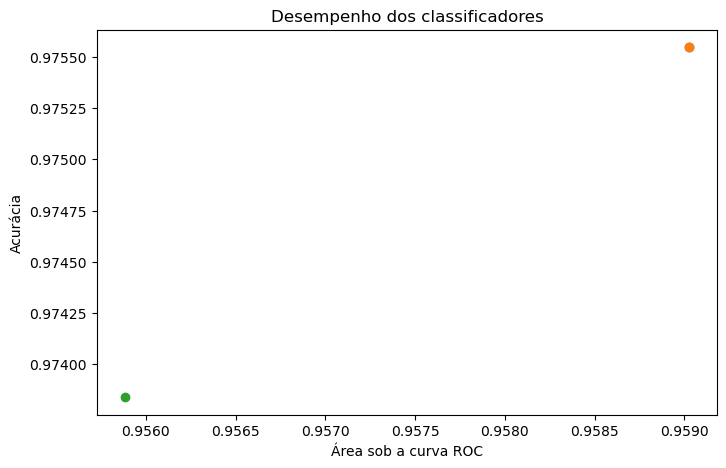

In [73]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.to_dict('records'):
    label = record['name']
    x = record['auc']
    y = record['accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores')
# ax.legend()
plt.show()


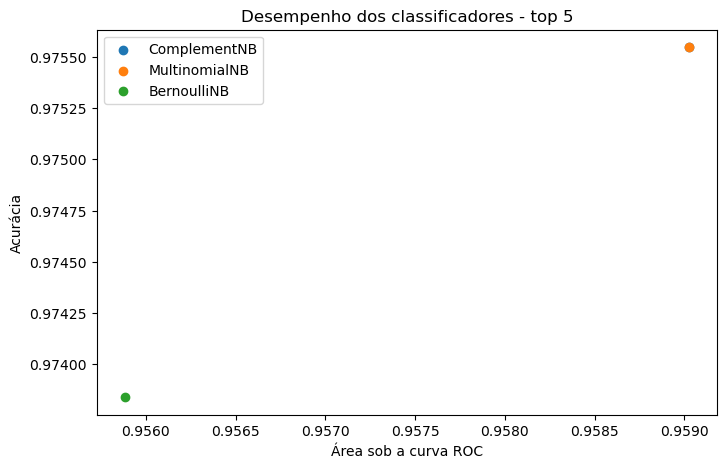

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.head(5).to_dict('records'):
    label = record['name']
    x = record['auc']
    y = record['accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores - top 5')
ax.legend()
plt.show()

## Ajustando hiperparâmetros do vetorizador

### RandomForestClassifier

In [ ]:
# %%time

# clf = RandomForestClassifier(
#     criterion = 'log_loss',
#     max_features = 'log2', 
#     n_estimators = 500
# )

# vectorizer = TfidfVectorizer()
# pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

# parameter_grid = {
#     "vectorizer__use_idf": (True, False),
#     "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "vectorizer__min_df": (1, 3, 5, 10),
#     "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "vectorizer__norm": ("l1", "l2"),
#     "vectorizer__tokenizer": (None, tokenizer),
# }
# scoring = {"AUC": "roc_auc"}

# gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=1)
# gs.fit(X_train, y_train)

# save_vectorizer_params()

### NuSVC

In [ ]:
# %%time

# clf = NuSVC(
#     kernel = 'rbf', 
#     nu = 0.25, 
#     tol = 1e-05
# )

# vectorizer = TfidfVectorizer()
# pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

# parameter_grid = {
#     "vectorizer__use_idf": (True, False),
#     "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "vectorizer__min_df": (1, 3, 5, 10),
#     "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "vectorizer__norm": ("l1", "l2"),
#     "vectorizer__tokenizer": (None, tokenizer),
# }
# scoring = {"AUC": "roc_auc"}

# gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=1)
# gs.fit(X_train, y_train)

# save_vectorizer_params()

### SGDClassifier

In [ ]:
# %%time

# clf = SGDClassifier(
#     alpha = 1e-05, 
#     loss = 'log_loss', 
#     penalty = 'l2'
# )

# vectorizer = TfidfVectorizer()
# pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

# parameter_grid = {
#     "vectorizer__use_idf": (True, False),
#     "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "vectorizer__min_df": (1, 3, 5, 10),
#     "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "vectorizer__norm": ("l1", "l2"),
#     "vectorizer__tokenizer": (None, tokenizer),
# }
# scoring = {"AUC": "roc_auc"}

# gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=1)
# gs.fit(X_train, y_train)

# save_vectorizer_params()

### LogisticRegression

In [ ]:
# %%time

# clf = LogisticRegression(
#     C = 10,
#     penalty = 'l2'
# )

# vectorizer = TfidfVectorizer()
# pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

# parameter_grid = {
#     "vectorizer__use_idf": (True, False),
#     "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "vectorizer__min_df": (1, 3, 5, 10),
#     "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "vectorizer__norm": ("l1", "l2"),
#     "vectorizer__tokenizer": (None, tokenizer),
# }
# scoring = {"AUC": "roc_auc"}

# gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=1)
# gs.fit(X_train, y_train)

# save_vectorizer_params()

### LinearSVC

In [ ]:
# %%time

# clf = LogisticRegression(
#     C = 0.1,
#     loss = 'squared_hinge', 
#     tol = 0.01
# )

# vectorizer = TfidfVectorizer()
# pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

# parameter_grid = {
#     "vectorizer__use_idf": (True, False),
#     "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "vectorizer__min_df": (1, 3, 5, 10),
#     "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "vectorizer__norm": ("l1", "l2"),
#     "vectorizer__tokenizer": (None, tokenizer),
# }
# scoring = {"AUC": "roc_auc"}

# gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=1)
# gs.fit(X_train, y_train)

# save_vectorizer_params()